In [1]:
import os

import datetime
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry.point import Point
import xarray
import wavespectra
import contextily as cx

import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import windrose
from windrose import WindroseAxes
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import rasterio
from rasterio.plot import show

from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates

## Set file paths

In [2]:
fp_geo = r"C:\Users\z3541792\OneDrive - UNSW\Research\ShoreShop2.0\data\curlcurl\shoreline\Image\CurlCurl"
fp_sl = os.path.join(fp_geo, 'CurlCurl_reference_shoreline.geojson')
fp_tran = r'datasets\transect_coords.geojson'
fp_wavecoord = r'datasets\nearshorewave_coords.geojson'
fp_bathy = r'datasets\bathymetry.tif'

fp_wave = r"datasets\hindcast_waves\offshore_wave.nc"

## Read data

In [3]:
ds = xr.open_dataset(fp_wave)
Hs = ds.Hs.values
Tp = ds.Tp.values
Dir = ds.Dir.values
lon_wave = ds.longitude.values.item()
lat_wave = ds.latitude.values.item()
# ds = ds.rename({'frequency' : 'freq', 'direction' : 'dir'})
# ds['efth'] = ds['efth'] * np.pi /180
# ds['dir'] = ds['dir'] - 180
# ds['dir'] = np.where(ds['dir']<0, ds['dir']+360, ds['dir'])
# lon_wave = ds.longitude.values.item()
# lat_wave = ds.latitude.values.item()
# Hs = ds.efth.spec.hs().values
# Tp = ds.efth.spec.tp().values
# Dir = ds.efth.spec.dm().values

C:\Users\z3541792\AppData\Local\anaconda3\envs\wave_env\Lib\site-packages\ecmwflibs\__init__.py:81: UserWarning: DLL load failed while importing _ecmwflibs: The specified procedure could not be found.
  warnings.warn(str(e))
C:\Users\z3541792\AppData\Local\anaconda3\envs\wave_env\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
# # Save offshore wave data
# time = ds.time.values
# ds_param = xr.Dataset(
#     {
#         "Hs": (["time"], Hs),
#         "Tp": (["time"], Tp),
#         "Dir": (["time"], Dir),
#     },
#     coords={
#         "time": time,
#         "longitude": lon_wave,
#         "latitude": lat_wave,
#     }
# )
# ds_param = ds_param.resample(time='D').mean()
# ds_param.to_netcdf("datasets/hindcast_waves/offshore_wave.nc")

In [5]:
gdf_sl = gpd.read_file(fp_sl).to_crs('EPSG:4326')
minx, miny, maxx, maxy = gdf_sl.geometry.bounds.values[0]
gdf_tran = gpd.read_file(fp_tran).to_crs('EPSG:4326')
gdf_wavecoord = gpd.read_file(fp_wavecoord).to_crs('EPSG:4326')

buoy_coords = [151.4117, -33.7739]

points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

with rasterio.open(fp_bathy) as src:
    bathy_img = src.read()
    bathy_img = np.where(bathy_img<0, np.nan, bathy_img)

In [6]:
fp = 'datasets' #File path
fn_obs =  'shorelines_obs.csv' # File name for shoreline observation
fn_targ_short =  'shorelines_hidden_short.csv' # File name for short-term shoreline prediction target
fn_targ_medium =  'shorelines_hidden_medium.csv' # File name for medium-term shoreline prediction target
fn_gt =  'shorelines_groundtruth.csv' #File name for groudtruth
target_trans = ['Transect2', 'Transect5', 'Transect8'] # Target transects for evaluation
shoreline_orientation = 35 # Shorelkine orientation (degrees)
sep_time = datetime.datetime(year=1986, month=1, day=1)

# Read shoreline data
df_gt = pd.read_csv(os.path.join(fp, 'shorelines', fn_gt), index_col='Datetime')
df_gt.index = pd.to_datetime(df_gt.index)

df_targ_short = pd.read_csv(os.path.join(fp, 'shorelines', fn_targ_short), index_col='Datetime')
df_targ_short.index = pd.to_datetime(df_targ_short.index)

df_targ_medium = pd.read_csv(os.path.join(fp, 'shorelines', fn_targ_medium), index_col='Datetime')
df_targ_medium.index = pd.to_datetime(df_targ_medium.index)

df_obs = pd.read_csv(os.path.join(fp, 'shorelines', fn_obs), index_col='Datetime')
df_obs.index = pd.to_datetime(df_obs.index)

WAVE_PARAMS = ['Hs', 'Tp', 'Dir'] 

dfs_wave = {}
for wave_param in WAVE_PARAMS:
    df_wave = pd.read_csv(
        os.path.join(fp, 'hindcast_waves' ,'{}.csv'.format(wave_param)),
        index_col = 'Datetime'
    )
    df_wave.index = pd.to_datetime(df_wave.index)
    dfs_wave[wave_param] = df_wave

df_SLR_obs = pd.read_csv(
    os.path.join(fp, 'sealevel', 'sealevel_obs.csv'),
    index_col = 'Year')
df_SLR_proj = pd.read_csv(
    os.path.join(fp, 'sealevel', 'sealevel_proj.csv'),
    index_col = 'Year')

C:\Users\z3541792\AppData\Local\Temp\ipykernel_24592\3348752839.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  main_ax.text(gdf_sl.geometry.centroid[0].xy[0][0]-0.05, gdf_sl.geometry.centroid[0].xy[1][0]+0.01, 'Beach X: Curl Curl',  color='r')
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
C:\Users\z3541792\AppData\Local\Temp\ipykernel_24592\3348752839.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'interpolate' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_tran.interpolate(0).plot(ax=ax, color='y', markersize=100)
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
C:\Users\z3541792\AppData\Local\anaconda3\envs\wave_env\Lib\site-packages\geopandas

Hs:1.1793068665671653
Tp:9.110097406700913
Dir:114.06228404017459


C:\Users\z3541792\AppData\Local\Temp\ipykernel_24592\3348752839.py:150: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_SDS = pd.concat([df_targ_medium.resample('1M').mean(), df_obs, df_targ_short])


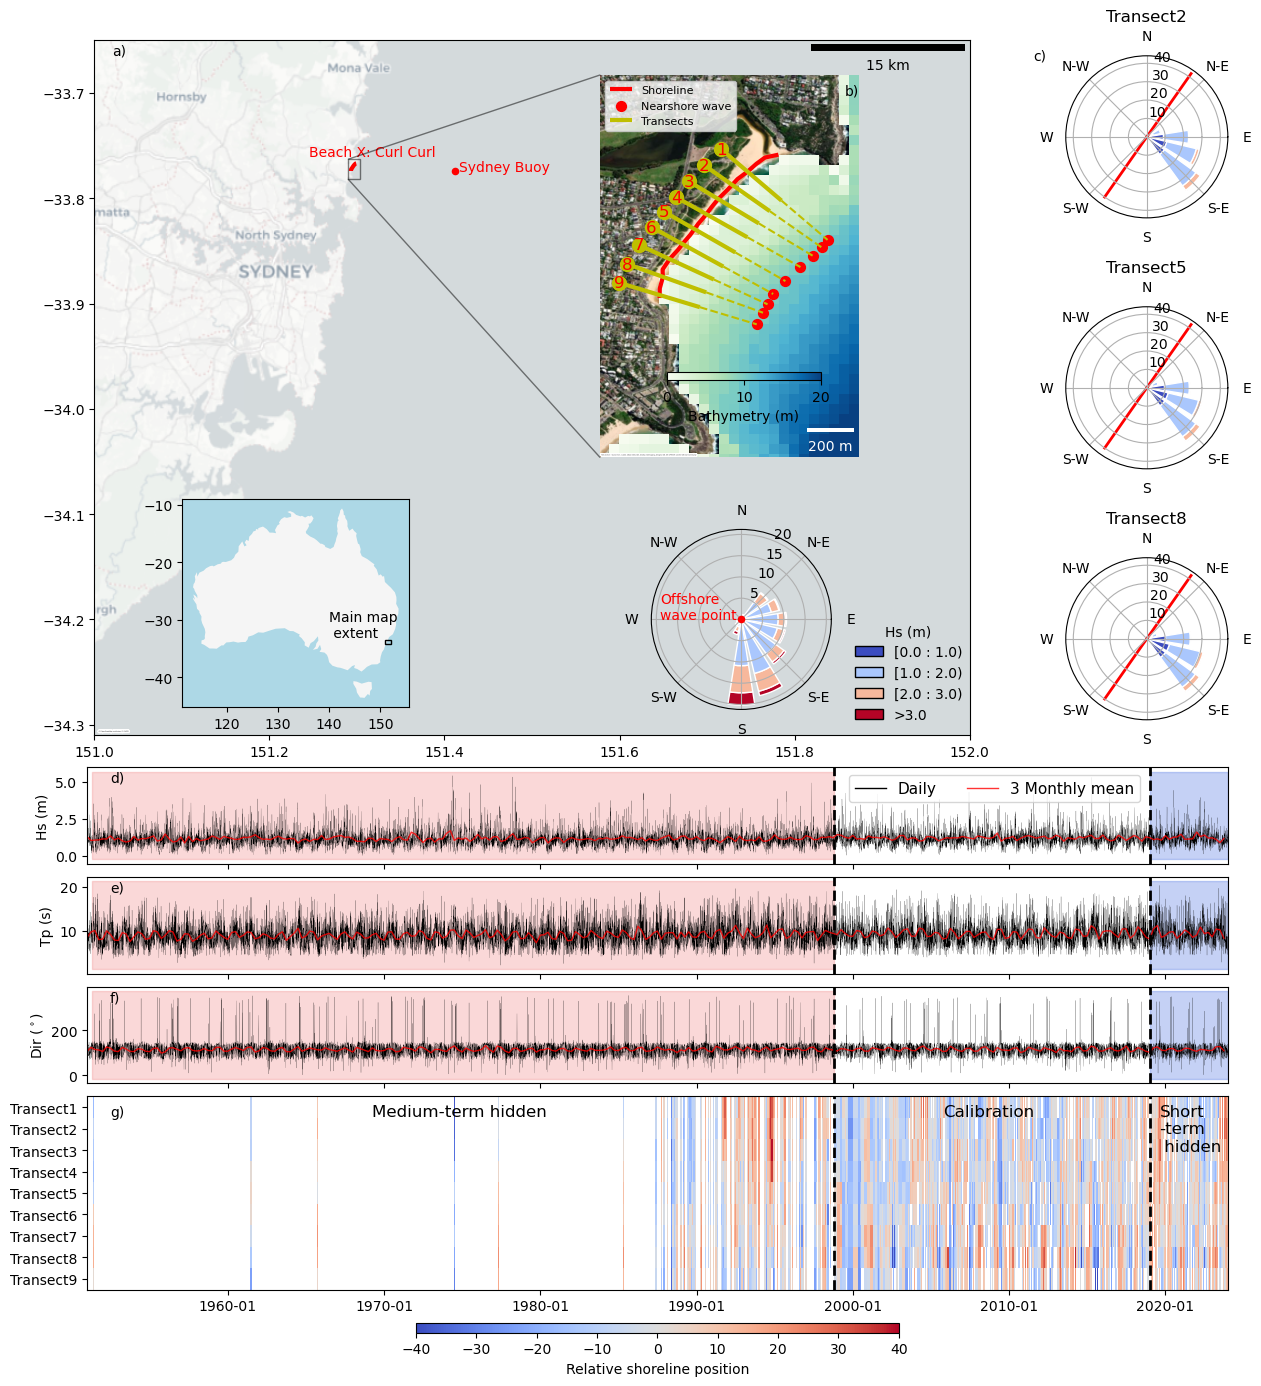

In [17]:
fig = plt.figure(layout="constrained", figsize = (12.5, 13.75))

gs = GridSpec(7, 5, figure=fig, width_ratios=[3, 3, 3, 3, 3], height_ratios=[3, 3, 3, 1.5, 1.5, 1.5, 3])
main_ax = fig.add_subplot(gs[0:3, 0:4])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
main_ax2 = WindroseAxes(fig, gs[0, 4]) 
main_ax2 = fig.add_subplot(main_ax2)
main_ax3 = WindroseAxes(fig, gs[1, 4]) 
main_ax3 = fig.add_subplot(main_ax3)
main_ax4 = WindroseAxes(fig, gs[2, 4]) 
main_ax4 = fig.add_subplot(main_ax4)
main_ax5 = fig.add_subplot(gs[3, :])
main_ax6 = fig.add_subplot(gs[4, :])
main_ax7 = fig.add_subplot(gs[5, :])
main_ax8 = fig.add_subplot(gs[6, :])


#====================================
# Plot map
#====================================
main_ax.text(0.02, 0.98, 'a)', transform=main_ax.transAxes)
main_ax.set_xlim(151, 152)
main_ax.set_ylim(-34.31, -33.65)

#gdf_sl.centroid.plot(ax=main_ax, color='r', markersize=100)
gdf_sl.plot(ax=main_ax, color='r', linewidth=3)
main_ax.text(gdf_sl.geometry.centroid[0].xy[0][0]-0.05, gdf_sl.geometry.centroid[0].xy[1][0]+0.01, 'Beach X: Curl Curl',  color='r')
cx.add_basemap(main_ax, crs=gdf_sl.crs, source=cx.providers.CartoDB.Positron, attribution_size=0)
main_ax.scatter(buoy_coords[0], buoy_coords[1], marker='o', color='r', s=20)
main_ax.text(buoy_coords[0]+0.005, buoy_coords[1], 'Sydney Buoy', color='r')


ax = main_ax.inset_axes([0.55, 0.4, 0.35, 0.55], xlim=(minx-0.003, maxx+0.004), ylim=(miny-0.008, maxy+0.004))
ax.text(0.95, 0.95, 'b)', transform=ax.transAxes)

gdf_sl.plot(ax=ax, color='r', linewidth=3, label='Shoreline')
gdf_wavecoord.plot(ax=ax, color='r', markersize=50, label='Nearshore wave')
gdf_tran.plot(ax=ax, color='y', linewidth=3, label='Transects')
gdf_tran.interpolate(0).plot(ax=ax, color='y', markersize=100)

for i, row in gdf_tran.iterrows():
    ax.plot([row.geometry.interpolate(row.geometry.length).xy[0][0], gdf_wavecoord.loc[gdf_wavecoord['TransectId']==row['name'], 'geometry'].values[0].xy[0][0]],
           [row.geometry.interpolate(row.geometry.length).xy[1][0], gdf_wavecoord.loc[gdf_wavecoord['TransectId']==row['name'], 'geometry'].values[0].xy[1][0]],
           linestyle='--',
           color='y')
    ax.text(row.geometry.interpolate(0).xy[0][0], row.geometry.interpolate(0).xy[1][0], row['name'][-1], fontsize=12, color='r',
           ha='center', va='center')
           #bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1', alpha=0.5))
cx.add_basemap(ax, crs=gdf_sl.crs, source=cx.providers.Esri.WorldImagery, attribution_size=0)
retted = show(bathy_img, transform=src.transform, cmap='GnBu', ax=ax, vmin=0, vmax=20)
im = retted.get_images()[1]
cax = fig.colorbar(im, ax=ax, orientation='horizontal', label='Bathymetry (m)', anchor=(0.75, 1.5), shrink=0.5)
ax.axis('off')
ax.add_artist(ScaleBar(distance_meters, box_alpha=0, color='white', location='lower right'))
ax.legend(loc=2, fontsize=8)


main_ax.indicate_inset_zoom(ax, edgecolor="black")
main_ax.add_artist(ScaleBar(distance_meters, box_alpha=0))
# ax.set_xlim(minx-0.003, maxx+0.004)
# ax.set_ylim(miny-0.008, maxy+0.004)

ax2 = main_ax.inset_axes([0.08, 0.04, 0.3, 0.3])
world[world['name']=='Australia'].plot(ax=ax2, color='whitesmoke')
rect = patches.Rectangle((151, -34.3), 1, 0.7, linewidth=1, edgecolor='k', facecolor='none')
ax2.add_patch(rect)
ax2.set_facecolor('lightblue')
ax2.text(140, -33, 'Main map\n extent')



wrax = inset_axes(
    main_ax,
    width=1.8,  # size in inches
    height=1.8,  # size in inches
    loc="center",  # center bbox at given position
    bbox_to_anchor=(lon_wave, lat_wave),  # position of the axe
    bbox_transform=main_ax.transData,  # use data coordinate (not axe coordinate)
    axes_class=windrose.WindroseAxes,  # specify the class of the axe
)
wrax.patch.set_alpha(0)

wrax.bar(Dir, Hs, normed=True, opening=0.8, bins=[0, 1, 2, 3], 
    cmap=cm.coolwarm, edgecolor='white')
wrax.set_rgrids([5, 10, 15, 20], [5, 10, 15, 20])

cbar = wrax.legend(loc=(1.1, -0.1), title='Hs (m)')
cbar.get_frame().set_alpha(0)
wrax.scatter(0.5, 0.5, marker='o', color='r', s=20, transform=wrax.transAxes, zorder=100)
wrax.text(0.05, 0.5, 'Offshore\nwave point', transform=wrax.transAxes, color='r')


#====================================
# Plot nearshore wave roses
#====================================
axes = [main_ax2, main_ax3, main_ax4]
labels = ['b', 'c', 'd']
for i, tran_id in enumerate(target_trans):
    ax = axes[i]
    #ax.text(-0.2, 0.98, '{})'.format(labels[i]), transform=ax.transAxes)
    if i == 0:
        ax.text(-0.2, 0.98, '{})'.format('c'), transform=ax.transAxes)
    
    # Plot wave rose for Hs
    ax.bar(dfs_wave['Dir'][tran_id], dfs_wave['Hs'][tran_id], normed=True, opening=0.8, bins=[0, 1, 2, 3], 
        cmap=cm.coolwarm, edgecolor='white')
    ax.set_rgrids([10, 20, 30, 40], [10, 20, 30, 40])
    ax.set_rlabel_position(85)
    ax.set_title(tran_id)
    
    theta = np.deg2rad(90-shoreline_orientation)
    opposite_theta = np.deg2rad(270-shoreline_orientation)  # opposite angle
    ax.plot([opposite_theta, opposite_theta], [0, ax.get_rmax()], color='red', linewidth=2, label='Shoreline Orientation', zorder=-100)
    ax.plot([theta, theta], [0, ax.get_rmax()], color='red', linewidth=2, label='Shoreline Orientation', zorder=-100)

#====================================
# Plot wave time series
#====================================
axes = [main_ax5, main_ax6, main_ax7]
labels = ['d', 'e', 'f']
x_labels = ['Hs (m)', 'Tp (s)', 'Dir ($^\circ$)']
for i, wave_param in enumerate(WAVE_PARAMS):
    # Calculate the average 
    df_mean = dfs_wave[wave_param].mean(1)
    print('{}:{}'.format(wave_param, df_mean.mean()))
    ax = axes[i]
    ax.text(0.02, 0.85, '{})'.format(labels[i]), transform=ax.transAxes)
    ax.plot(df_mean.index, df_mean.values, color='k', linewidth=0.1)
    ax.plot([], [], color='k', linewidth=1, label='Daily')
    ax.plot(df_mean.resample('3MS').mean().index, df_mean.resample('3MS').mean().values, color='r', linewidth=1, alpha=0.8,
           label='3 Monthly mean')
    ylim_up, ylim_down = ax.get_ylim()
    ax.fill_between(df_targ_medium.index, ylim_down, ylim_up, alpha=0.3, 
                    color='lightcoral')
    ax.fill_between(df_targ_short.index, ylim_down, ylim_up, alpha=0.3, 
                    color='royalblue')
    ax.axvline(df_targ_medium.index[-1], 0, 1, color='k', linestyle='--', linewidth=2)
    ax.axvline(df_targ_short.index[0], 0, 1, color='k', linestyle='--', linewidth=2)
    ax.set_ylabel(x_labels[i])
    if i == 0:
        ax.legend(ncol=4, loc=1, bbox_to_anchor=(0.93, 1), fontsize=11)
    ax.set_xlim(datetime.datetime(year=1951, month=1, day=1), datetime.datetime(year=2024, month=1, day=1))
    ax.set_xticklabels([])

#====================================
# Plot heat map
#====================================
ax = main_ax8
ax.text(0.02, 0.9, 'g)', transform=ax.transAxes)
df_SDS = pd.concat([df_targ_medium.resample('1M').mean(), df_obs, df_targ_short])
df_SDS_rel = (df_SDS - df_SDS.median(0))
x = mdates.date2num(df_SDS_rel.index)  # Convert datetime to float for pcolormesh
y = np.arange(len(df_SDS_rel.columns))[::-1]  # This will be your transect indices

# Create the meshgrid for plotting
X, Y = np.meshgrid(x, y)
Z = df_SDS_rel.T.values  # Shape should be (n_transects, n_dates)

# Set up the plot with pcolormesh
hmap = ax.pcolormesh(X, Y, Z, shading='auto', cmap='coolwarm', vmin=-40, vmax=40)

# Draw vertical lines and add text labels
ax.axvline(df_targ_medium.index[-1], 0, 1, color='k', linestyle='--', linewidth=2)
ax.axvline(df_targ_short.index[0], 0, 1, color='k', linestyle='--', linewidth=2)
ax.text(0.25, 0.9, 'Medium-term hidden', transform=ax.transAxes, fontsize=12)
ax.text(0.75, 0.9, 'Calibration', transform=ax.transAxes, fontsize=12)
ax.text(0.94, 0.72, 'Short\n-term\n hidden', transform=ax.transAxes, fontsize=12)

# Set the color bar
plt.colorbar(hmap, label='Relative shoreline position', orientation='horizontal', location='bottom',
            aspect=50, fraction=0.05, shrink=0.5)

# Configure x-axis for datetime
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set y-ticks to show transect labels in reverse
ax.set_yticks(ticks=y, labels=df_SDS_rel.columns)  # Reverse the labels to match the y-axis
ax.set_xlim(datetime.datetime(year=1951, month=1, day=1), datetime.datetime(year=2024, month=1, day=1))

#====================================
# Plot sea level rise
#====================================
# ax = main_ax6
# a, b = np.polyfit(df_SLR_obs.index, df_SLR_obs['Sealevel (m)'], 1)
# ax.plot(df_SLR_obs.index, df_SLR_obs['Sealevel (m)'], color='k', linestyle='-', label='Observation')
# ax.plot(df_SLR_obs.index, a*df_SLR_obs.index+b, color='k', linestyle='--', label='Trend of observation')
# ax.plot(df_SLR_proj.index, df_SLR_proj['RCP85'], color='r', linestyle='-', label='RCP8.5 Projection')
# ax.plot(df_SLR_proj.index, df_SLR_proj['RCP45'], color='g', linestyle='-', label='RCP4.5 Projection')

# ax.set_xlabel('Year')
# ax.set_ylabel('Sea level (m)')

# ax.legend(ncol=4)
plt.savefig('figures/paper/Fig1.jpg', dpi=300, bbox_inches='tight') 